# Larry's Analytics Compendium

In [31]:
import pandas as pd
import numpy as np
import scipy as sp
import statsmodels.api as sm
import math

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

pd.options.display.max_columns = None
pd.options.display.max_rows = None

%matplotlib inline

# show all output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Table of Contents

**[Probability](#Probability)**<br>
* [Bayes Theorem](#Bayes-Theorem)
* [Unions & Intersections](#Unions-&-Intersections)

**[Distributions](#Distributions)**<br>
* [PMF & PDF](#PMF-&-PDF)
* [CDF](#CDF-&-ECDF)
* [Bernoulli](#Bernoulli)
* [Geometric](#Geometric)
* [Binomial](#Binomial)
* [Poisson](#Poisson)
* [Normal](#Normal)

**[Misc](#Misc)**<br>
[Signal Processing](#Signal-Processing)
* [Measuring Spikes in a Temporal Signal](#Measuring-Spikes-in-a-Temporal-Signal)

---

# Probability

## Bayes Theorem

A customer visits the store:

* Let C represent the event that the customer visiting the store purchases a product (nonzero probability)

* Let A represent the event that the customer visiting the store is Type A

* Let B represent the event that the customer visiting the store is Type B


$P(C|A)$ 
* c_a - probability that the customer purchases a product, given they are Type A

$P(C|B)$ 
* c_b - probability that the customer purchases a product, given they are Type B

$P(A) = 1 - P(B) = P(B^c)$ 
* a, b - probability that the customer is Type A, B
* A is the complement of B (assuming no other customer types)

$P(A|C) = \frac{P(A\cap C)}{P(C)}= \frac{P(C|A)P(A)}{P(C)} = \frac{P(C|A)P(A)}{P(C|A)P(A) + P(C|B)P(B)}$

In [50]:
### Assuming known probability that a customer purchases a product, given they are Type A, B (c_a, c_b):
### Write a single parameter function that calculates the probability that a customer visiting the store is Type A, given they purchased a product

def type_A_customer(a):
    # Probability that customer is Type B (not Type A)
    b = 1 - a
    # Probability of purchases based on customer Type
    c_a = 0.01
    c_b = 0.1
    # Probability that a customer purchases a product
    c = ((c_a * a) + (c_b * b))
    
    return (c_a * a) / c

In [51]:
print('50%% of customers are type A: %.2f' %(type_A_customer(0.5)))
print('60%% of customers are type A: %.2f' %(type_A_customer(0.6)))

50% of customers are type A: 0.09
60% of customers are type A: 0.13


## Unions & Intersections

Assuming A and B are mutually independent events

**Union**

$A \cap B$ - All outcomes that are elements of both A and B

$P(A \cap B) = P(A) \times P(B)$

A and B are mutually exclusive: $P(A \cap B) = 0$

**Intersection**

$A \cup B$ - All outcomes that are elements of either A and B or both

$P(A \cup B) = P(A) + P(B) - P(A \cap B)$

Higher order


$P(A \cup B \cup C) = P(A) + P(B) + P(C) - P(A \cap B) - P(A \cap C) - P(B \cap C) + P(A \cap B \cap C)$

$P(E_1 \cup E_2 ... E_n) = \sum\limits_{i\in n}P(E_i) - \sum\limits_{i < j}P(E_i \cap E_j) + \sum\limits_{i < j < k}P(E_i \cap E_j \cap E_k) ... + (-1)^nP(E_1 \cap E_2 ... E_n)$

In [473]:
def random_card_draw():
    values = "2, 3, 4, 5, 6, 7, 8, 9, 10, J, K, Q, A".split(', ')
    suits = {'C': 'B', 'S': 'B', 'H': 'R', 'D': 'R'}
    deck = [{'Value': v, 'Suit': s, 'Color': suits[s]} for v in values for s in list(suits.keys())]
    c = np.random.choice(deck)
    return c

In [474]:
random_card_draw()

{'Value': 'J', 'Suit': 'S', 'Color': 'B'}

In [478]:
n = 10000
is_black_and_queen = np.zeros(n)
is_black_or_queen = np.zeros(n)
is_black = np.zeros(n)
is_queen = np.zeros(n)

for i in range(n):
    random_draw = random_card_draw()
    if random_draw['Color'] == 'B' and random_draw['Value'] == 'Q':
        is_black_and_queen[i] = 1
    if random_draw['Color'] == 'B':
        is_black[i] = 1
        is_black_or_queen[i] = 1
    if random_draw['Value'] == 'Q':
        is_queen[i] = 1
        is_black_or_queen[i] = 1

In [479]:
is_black.mean() + is_queen.mean() - is_black_and_queen.mean()

0.5482

In [583]:
is_black_or_queen.mean()

0.5482

---

# Distributions

Random variable - variable with a defined set of outcomes (sample space) whose value depends on a random phenomenon. Can be simulated if parameters are known.

Probability Distribution - describes the probability that a random variable takes a particular value in its defined sample space. Can be fitted to a dataset using MLE to estimate parameters.
* Probability mass function - discrete
* Probability density function - continuous
* [Cumulative density function](#Cumulative-Distribution-Functions-(CDF)-&-Empirical-CDF)

## PMF & PDF

Probability Mass Function (PMF) - Discrete Random Variable

Probability Density Function (PDF) - Continuous Random Variable

PMF: $p(x_i) = P(X=x_i)$

PDF: $f(x)$ &ensp;s.t.&ensp; $p(a \leq X \leq b) = \int_a^bf(x)dx$

Sum of probabilities across a random variable's sample space = 1

$\sum\limits_{i \in I} p(x_i) = 1$

$\int_{-\infty}^{\infty}f(x)dx = 1$

## CDF & ECDF

CDF of a random variable *X* is the probability that *X* will take a value less than or equal to a certain threshold *x*. Practically the same as percentile (though not in theory).

$F(x) = P(X\leq x) = \int_{-\infty}^xf(t)dt$ &emsp; ; &emsp; $f(x) = \frac{d}{dx}F(x)$

$P(a < X \leq b) = F(b) - F(a)$

In [141]:
def ecdf(x):
    x = np.sort(x)
    n = len(x)
    y = np.arange(1, n + 1) / n
    return x, y

---

## Bernoulli

Distribution describes a binary random variable (discrete) that takes value **1** with probability $p$ and value **0** with probability $q=1-p$ (i.e. single coin toss). Special case of [Binomial distribution](#Binomial) where n=1.

**Parameters**

$k\in\{0, 1\}$ - outcomes

$p$ - probability of success (1)

$q = 1 - p$ - probability of failure (0)

**PMF**

$f(k, p) = p^k(1 - p)^{k-1}$

$f(1, p) = p$

$f(0, p) = (1-p) = q$

**Moments**

$\mu = p$

$Var(x) = p(1-p) = pq$

In [52]:
### Fair coin
np.random.binomial(size=1, n=1, p=0.5)

array([1])

In [53]:
### Unfair coin
np.random.binomial(size=1, n=1, p=0.3)

array([1])

## Geometric

Distribution describes the number of [Bernoulli](#Bernoulli) trials needed to see one success
* Random Variable takes values {1, 2, 3, 4, ...}
* Success trial included (shifted)

**Parameters**

$k\in \{1, 2, 3, 4, ...\}$ - number of Bernoulli trials

$p$ - probability of success

**PMF**

$f(k) = (1-p)^{k-1}p$

**Moments**

$\mu = 1/p$

$Var(x) = \frac{1-p}{p^2}$

In [564]:
p = 0.20
np.random.geometric(p)

2

In [565]:
bern_sim = np.empty(10000)

for i in range(10000):
    g = min([i+1 for i, x  in enumerate(np.random.binomial(size=100, n=1, p=p)) if x > 0] + [101])
    bern_sim[i] = g

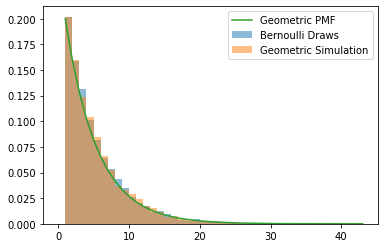

In [573]:
geo_sim = np.random.geometric(p=p, size=10000)
bins = np.arange(0, int(max(np.max(geo_sim), np.max(bern_sim))) + 1)
hist_params = {'alpha': 0.5, 'density': True, 'bins': bins}

plt.hist(bern_sim, **hist_params)
plt.hist(geo_sim, **hist_params)
plt.plot(np.arange(1, max(bins)+1), sp.stats.geom(p).pmf(k=np.arange(1, max(bins)+1)))
plt.legend(['Geometric PMF', 'Bernoulli Draws', 'Geometric Simulation']);

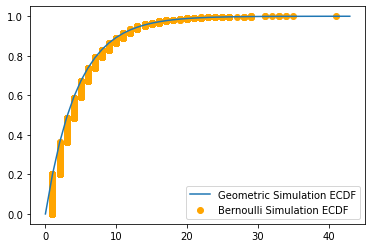

In [577]:
plt.scatter(*ecdf(geo_sim), color='orange')
plt.plot(sp.stats.geom(p).cdf(np.arange(0, max(bins)+1)))
plt.legend(['Geometric Simulation ECDF', 'Bernoulli Simulation ECDF', 'Geometric CDF']);

## Binomial

Distribution describes the number of successes *k* in a sequence of *n* **independent** [Bernoulli](#Bernoulli) trials each with probability *p* (i.e. number of heads if you flip a coin 20 times).
* Discrete random variable - *k*
* Bernoulli trials are **independent** - outcome of one Bernoulli trial does not affect outcome of another Bernoulli trial
    - don't expect the next coin flip to be heads just because the last 10 have been tails
* With large n, the Binomial distribution of a discrete random variable can be approximated by [normal distribution](#Normal) of continuous random variable

**Parameters**

$n$ - number of Bernoulli trials

$k\in[0, n]$ - number of successes

$p$ - probability of success per single Bernoulli trial

$q = 1 - p$ - probability of failure per single Bernoulli trial

**PMF**

$f(n, k, p) = \binom{n}{k}p^k(1 - p)^{n-k}$

$\binom{n}{k} = \frac{n!}{k!(n-k)!}$

**Moments**

$\mu = np$

$Var(x) = npq$

In [166]:
### size = number of binomial samples
### n = number of bernoulli samples
### p = probability of bernoulli sample
binom = np.random.binomial(size=10, n=1, p=0.5)
print(binom)
print(binom.sum())

[0 0 0 1 0 0 1 1 0 1]
4


In [130]:
### Two different ways of sampling a binomial distribution with n=10 and p=0.5. Output = k
print(np.random.binomial(size=10, n=1, p=0.5).sum())
print(np.random.binomial(size=1, n=10, p=0.5)[0])

7
4


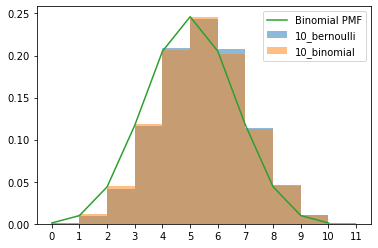

In [582]:
n = 10
p = 0.5
bern = np.empty(10000)
binom = np.empty(10000)
for i in range(10000):
    bern[i] = np.random.binomial(size=n, n=1, p=p).sum()
    binom[i] = np.random.binomial(size=1, n=n, p=p)
    
plt.hist(bern, alpha=0.5, bins=np.arange(0, n+2), density=True)
plt.hist(binom, alpha=0.5, bins=np.arange(0, n+2), density=True)
plt.plot(np.arange(0, n+1), sp.stats.binom.pmf(k=np.arange(0, n+1), p=p, n=n))
plt.xticks(np.arange(0, n+2, 1))
plt.legend(['Binomial PMF', f'{n}_bernoulli', f'{n}_binomial']);

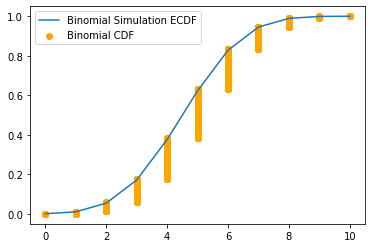

In [422]:
plt.scatter(*ecdf(binom), color='orange')
plt.plot(sp.stats.binom(n=n, p=p).cdf(np.arange(0, n+1)))
plt.legend(['Binomial Simulation ECDF', 'Binomial CDF']);

**Make a biased coin unbiased**

In [93]:
def biased_coin(p = 0.3):
    return np.random.binomial(size=1, n=1, p=p)[0]

In [105]:
def unbiased_coin():
    while True:
        f_1 = biased_coin()
        f_2 = biased_coin()
        if (f_1 == 1) and (f_2 == 0):
            return 1
        elif (f_1 == 0) and (f_2 == 1):
            return 0
        else:
            continue

In [120]:
coin_flips = np.empty(10000)
for i in range(10000):
    coin_flips[i] = unbiased_coin()
print(coin_flips.sum() / coin_flips.shape[0])

0.5032


## Poisson

Describes the probability of seeing a given number of events occur in in a fixed, defined unit of time/space (i.e. number of calls in response to a TV airing).
* Fixed average rate of occurrence ($\lambda$)
* Events are independent of each other
* Inverse of [exponential function](#Exponential), which can describe the time/space between events

**Parameters**

$\lambda$ - average rate of occurrence

$k$ - number of events

**PMF**

$f(k, \lambda) = \frac{\lambda^ke^{-\lambda}}{k!}$

**Moments**

$\mu = \lambda$

$Var(x) = \lambda$

In [362]:
lam = 10

In [363]:
### Random variable simulator
### lam = lambda -> parameter that describes average number of events per unit
np.random.poisson(lam=lam)

12

In [364]:
poisson_draws = np.random.poisson(lam=lam, size=100000)

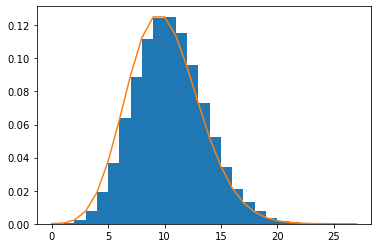

In [365]:
bins = plt.hist(poisson_draws, bins=range(np.min(poisson_draws), np.max(poisson_draws)), density=True)
plt.plot(sp.stats.poisson(lam).pmf(k=range(np.min(poisson_draws), np.max(poisson_draws) + 1)));

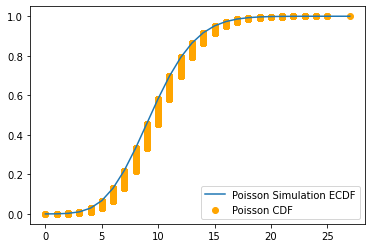

In [423]:
plt.scatter(*ecdf(poisson_draws), color='orange')
plt.plot(sp.stats.poisson(lam).cdf(range(np.min(poisson_draws), np.max(poisson_draws) + 1)))
plt.legend(['Poisson Simulation ECDF', 'Poisson CDF']);

In [367]:
np.mean(poisson_draws)

10.00652

In [383]:
df = pd.DataFrame(pd.DataFrame(poisson_draws).groupby(0)[0].count() / len(poisson_draws)).rename(columns={0: 'Sim_Freq'}).reset_index()
df = df.rename(columns={0: 'k'})
df.loc[:,'PMF'] = df.loc[:, 'k'].apply(lambda x: sp.stats.poisson(lam).pmf(x))
df['CDF'] = df['PMF'].cumsum()

In [384]:
df

,k,Sim_Freq,PMF,CDF
0,0,0.00004,0.000045,0.000045
1,1,0.00042,0.000454,0.000499
2,2,0.00227,0.002270,0.002769
3,3,0.00757,0.007567,0.010336
4,4,0.01940,0.018917,0.029253
5,5,0.03699,0.037833,0.067086
6,6,0.06425,0.063055,0.130141
7,7,0.08865,0.090079,0.220221
8,8,0.11180,0.112599,0.332820
9,9,0.12419,0.125110,0.457930


In [391]:
### 5 percentile of values
np.percentile(poisson_draws, 5)

5.0

In [392]:
sp.stats.poisson(lam).ppf(0.05)

5.0

In [584]:
### Expected value for values under 5th percentile
(df[df['k'] <= np.percentile(poisson_draws, 5)]['PMF'] * df['k']).sum() / df[df['k'] <= np.percentile(poisson_draws, 5)]['PMF'].sum()

4.360478231445974

You expect an average of 10 customers to visit your shop in a given hour. Some hours, you see more or less customers due to randomness. Each customer requires an individual employee to be served. A customer who has been served pays \\$12, whereas a customer who hasn't been served leaves and pays \\$0. You pay employees \\$10 an hour to be there. If you choose to staff 10 employees per hour, how much money are you losing in the worst 5\% of cases?

In [378]:
### Simulation
lam = 10
n = 100000
employees = 10
customer_draws = np.random.poisson(lam=lam, size=n)
customers = np.mean(customer_draws[customer_draws <= np.percentile(customer_draws, 5)])
revenue = customers * 12
costs = employees * 10
profits = revenue - costs
idle_employees = employees - customers
print('In the worst five percent of cases, you can expect to lose an average of $%.2f' %np.abs(profits))
print('In the worst five percent of cases, you can expect %d idle employees' %np.abs(np.round(idle_employees, 0)))

# idle_employees = employees - customer_draws
# worst_five_percent_avg_idle = np.mean(idle_employees[idle_employees >= np.percentile(idle_employees, 95)])
# print('In the worst five percent of cases, you can expect %d idle employees' %np.abs(np.round(worst_five_percent_avg_idle, 0)))

In the worst five percent of cases, you can expect to lose an average of $47.69
In the worst five percent of cases, you can expect 6 idle employees


In [359]:
### PPF from Distribution
lam = 10
employees = 10
threshold = sp.stats.poisson(lam).ppf(0.05)
customers = sp.stats.poisson(lam).expect(lb=-10000, ub=threshold, conditional=True)
revenue = customers * 12
costs = employees * 10
worst_five_percent_profits = revenue - costs
worst_five_percent_idle_employees = employees - worst_five_percent_customers
print('In the worst five percent of cases, you can expect to lose an average of $%.2f' %np.abs(worst_five_percent_profits))
print('In the worst five percent of cases, you can expect %d idle employees' %np.abs(np.round(worst_five_percent_idle_employees, 0)))

In the worst five percent of cases, you can expect to lose an average of $47.67
In the worst five percent of cases, you can expect 6 idle employees


## Normal

**Parameters**

$\mu$ - mean

$\sigma$ - standard deviation

**PMF**

$f(x| \mu, \sigma) = \frac{1}{\sigma \sqrt{2\pi}}e^{-\frac{1}{2}\big(\frac{x-\mu}{\sigma}\big)^2}$

**Moments**

$\mu = \mu$

$Var(x) = \sigma^2$

In [621]:
### loc=mu
### scale=sigma
mu=0
sigma=1
normal_draws = np.random.normal(loc=mu, scale=sigma, size=100000)

In [624]:
np.max(normal_draws)

4.479369739453257

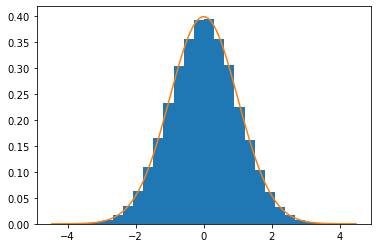

In [637]:
plt.hist(normal_draws, bins=30, density=True)
plt.plot(np.linspace(np.min(normal_draws), np.max(normal_draws), 100), sp.stats.norm(loc=mu, scale=sigma).pdf(x=np.linspace(np.min(normal_draws), np.max(normal_draws), 100)));

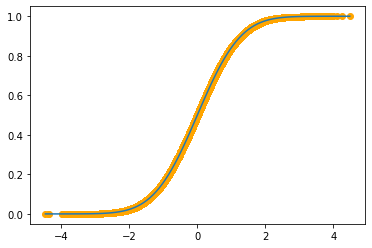

In [638]:
plt.scatter(*ecdf(normal_draws), color='orange')
plt.plot(np.linspace(np.min(normal_draws), np.max(normal_draws), 100), sp.stats.norm(loc=mu, scale=sigma).cdf(x=np.linspace(np.min(normal_draws), np.max(normal_draws), 100)));

**Standard Score**

Transforming a non-standard normal distribution to a standard normal distribution. Also known as z-statistic
* Requires population mean and standard deviation (can be bypassed for large sample sizes)
* If population mean and standard deviation are not known and sample size is small (<50), this turns into t-statistic

$Z = \frac{x - \mu}{\sigma}$

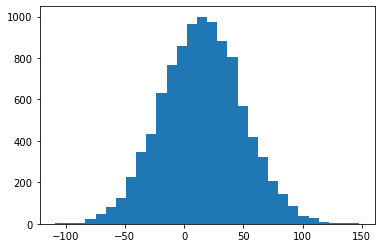

In [652]:
non_standard = np.random.normal(loc=np.random.uniform(10, 20), scale = np.random.uniform(20, 40), size=10000)
plt.hist(non_standard, bins=30);

Mean: -0.00
Standard Deviation: 1.00


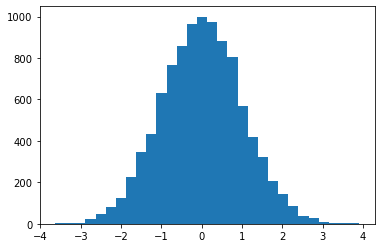

In [653]:
standard = (non_standard - np.mean(non_standard)) / np.std(non_standard)
plt.hist(standard, bins=30)
print("Mean: %.2f" %np.mean(standard))
print("Standard Deviation: %.2f" %np.std(standard));

**Central Limit Theorem**

**Binomial Approximation**

**Poisson Approximation**

## T

## Chi-Square

## F

## Exponential

---

# Moments of Statistics

**Mean** - First Moment

Expected value / Average

$\mu = E[X] = \sum\limits_{i\in I}x_ip(x_i)$ (Discrete)

$\mu = E[X] = \int\limits_{-\infty}^{\infty}xp(x)dx$ (Continuous)

Empirical

Unweighted: $\mu = \frac{\sum_{i=1}^{n}x_i}{n}$

Unweighted: $\mu = \frac{\sum_{i=1}^{n}x_iw_i}{\sum_{i=1}w_i}$

In [496]:
lam = 10
n = 10000
poisson_draws = np.random.poisson(lam=lam, size=n)
print("%.4f" %(np.sum(poisson_draws) / n))
print("%.4f" %np.mean(poisson_draws))
print("%.4f" %sp.stats.poisson(lam).expect())

9.9529
9.9529
10.0000


**Variance** - Second moment

Variance / deviation from the mean

$Var(x) = \sigma^2 = E[(X - E[X])^2] = E[X^2] - E[X]^2$

$Var(x) = \frac{\sum_i^N(x_i-\mu)^2}{N} = \frac{\sum_i^Nx_i^2}{N} - \mu^2$

**Skewness** - Third moment

**Kurtosis** - Fourth moment

# Fitting Distributions

## Parametric Estimation

## Kernel Density Estimation

# Statistical Tests

## KS Test

## Chow Test

# Bootstrapping

# Simulations

# Regressions

# Clustering

# Dimensionality Reduction

## PCA

# Ensemble Learning

# Tools

# Misc

## Signal Processing

### Measuring Spikes in a Temporal Signal

In [10]:
df = pd.DataFrame()
df['x'] = np.linspace(-10, 10, 1000)
df['y_b'] = (100 - (df['x']**2)) + np.random.uniform(-2, 2, 1000) + np.random.choice(a = [-20, 0, 20], p=[0.01, 0.98, 0.01], size=1000)
df['med_filter'] = df.rolling(window=5, center=True)['y_b'].median()
df['Spikes'] = np.abs(df['y_b'] - df['med_filter'])

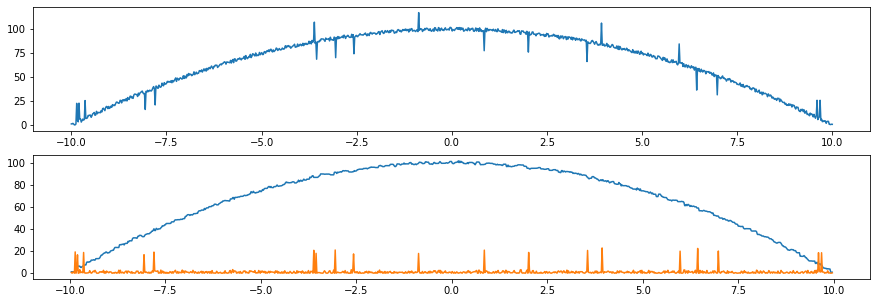

In [181]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,5))
ax[0].plot(df['x'], df['y_b'])
ax[1].plot(df['x'], df['med_filter'])
ax[1].plot(df['x'], df['Spikes']);